# Time Series Forecasting of Daily and Cumulative Cases of Covid-19 using Covid-19 Tweets as an External Regressor


In [1]:
# !pip install pystan
# !pip install fbprophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from chart_studio import plotly 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
# reference:
# https://towardsdatascience.com/simplified-forecasting-with-facebook-prophet-d5789d32acdf
# https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a
# https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
# https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

## Part I: Prediction of Daily Covid-19 Cases using Tweet Counts as an External Regressor

### Importing and Processing CDC Data for Covid-19 Cases in the US
Link: https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36

In [2]:
cdc_data = pd.read_csv('CDC_dataset.csv')

In [3]:
cdc_data.describe()

tot_cases    conf_cases     prob_cases      new_case     pnew_case  \
count  4.116000e+04  2.199100e+04   21919.000000  41160.000000  37159.000000   
mean   3.334831e+05  3.577318e+05   45340.923582   1190.070505    182.406039   
std    5.997560e+05  5.650308e+05   69517.962414   2544.563086    520.709600   
min    0.000000e+00  0.000000e+00       0.000000 -10199.000000 -10733.000000   
25%    5.450000e+03  3.349200e+04      12.000000     28.000000      0.000000   
50%    1.028975e+05  1.538920e+05    8195.000000    351.000000      4.000000   
75%    4.329145e+05  4.996240e+05   63843.500000   1267.000000    145.000000   
max    5.113467e+06  4.851429e+06  381613.000000  61016.000000  16591.000000   

          tot_death    conf_death    prob_death     new_death    pnew_death  
count  41160.000000  21771.000000  21771.000000  41160.000000  37098.000000  
mean    6178.508285   6902.206513    703.874007     18.815403      1.819209  
std    10332.127070   9309.179176   1094.737914     45.622450     27.823309  
min        0.000000      0.000000      0.000000   -352.000000  -2594.000000  
25%      116.000000    747.000000      0.000000      0.000000      0.000000  
50%     1865.000000   3460.000000    208.000000      4.000000      0.000000  
75%     7819.250000   9513.500000    901.000000     18.000000      1.000000  
max    74221.000000  71408.000000   5208.000000   1178.000000   2919.000000

In [4]:
cdc_data

submission_date state  tot_cases  conf_cases  prob_cases  new_case  \
0          04/01/2021    CA    3570660   3570660.0         0.0      2234   
1          05/31/2021    CA    3685032   3685032.0         0.0       644   
2          02/06/2020    NE          0         NaN         NaN         0   
3          07/30/2020    ME       3910      3497.0       413.0        22   
4          02/02/2021    MS     280182    176228.0    103954.0      1059   
...               ...   ...        ...         ...         ...       ...   
41155      07/19/2020    NJ     178541         NaN         NaN       -10   
41156      08/13/2021   FSM          7         7.0         0.0         0   
41157      12/15/2020    DC      25339         NaN         NaN       301   
41158      03/26/2020    SC        474       474.0         0.0        83   
41159      11/22/2021    AZ    1245127   1127692.0    117435.0      3249   

       pnew_case  tot_death  conf_death  prob_death  new_death  pnew_death  \
0            0.0      58090     58090.0         0.0        154         0.0   
1            0.0      62011     62011.0         0.0          5         0.0   
2            NaN          0         NaN         NaN          0         NaN   
3            2.0        123       122.0         1.0          2         0.0   
4          559.0       6730      4739.0      1991.0         13         7.0   
...          ...        ...         ...         ...        ...         ...   
41155       21.0      15706     13732.0      1974.0         34        27.0   
41156        0.0          0         0.0         0.0          0         0.0   
41157        0.0        720         NaN         NaN          4         0.0   
41158        0.0          5         NaN         NaN          1         0.0   
41159      403.0      21942     19414.0      2528.0          2         0.0   

                   created_at consent_cases consent_deaths  
0      04/03/2021 12:00:00 AM         Agree          Agree  
1      06/02/2021 12:00:00 AM         Agree          Agree  
2      03/26/2020 04:22:39 PM         Agree          Agree  
3      07/31/2020 02:35:06 PM         Agree          Agree  
4      02/04/2021 12:00:00 AM         Agree          Agree  
...                       ...           ...            ...  
41155  07/19/2020 12:00:00 AM     Not agree          Agree  
41156  08/14/2021 02:46:52 PM         Agree          Agree  
41157  12/16/2020 02:28:57 PM           NaN            NaN  
41158  03/26/2020 12:00:00 AM         Agree      Not agree  
41159  11/23/2021 02:18:53 PM         Agree          Agree  

[41160 rows x 15 columns]

Jurisdictions may reclassify probable cases at any time to confirmed cases (if confirmatory laboratory evidence is obtained) or withdraw probable case reports entirely if further public health investigation determines that the individual most likely did not have COVID-19. As a result, probable case counts can fluctuate substantially. A jurisdiction might even report a negative number of probable cases on a given day, if more probable cases were disproven than were initially reported on that day.

For our analysis, We will only be considering the confirmed case counts.

In [5]:
#Dropping columns which are not needed and renaming
cdc_data.drop(columns = ['tot_cases','tot_death','prob_cases','pnew_case','prob_death','pnew_death','consent_cases','consent_deaths','created_at'], inplace= True) 
cdc_data.rename(columns = {'submission_date':'Date','state':'State','conf_cases':'Total_cases_cum','new_case':'daily_cases','conf_death':'Total_deaths_cum','new_death':'daily_deaths'},inplace = True)
cdc_data['Date'] = pd.to_datetime(cdc_data['Date'])

For our analysis, we will need the overall counts for all of US. 

In [6]:
US_data = cdc_data.groupby('Date',as_index = True).sum()

Text(0.5, 1.0, 'Cumulative Covid-19 Case counts')

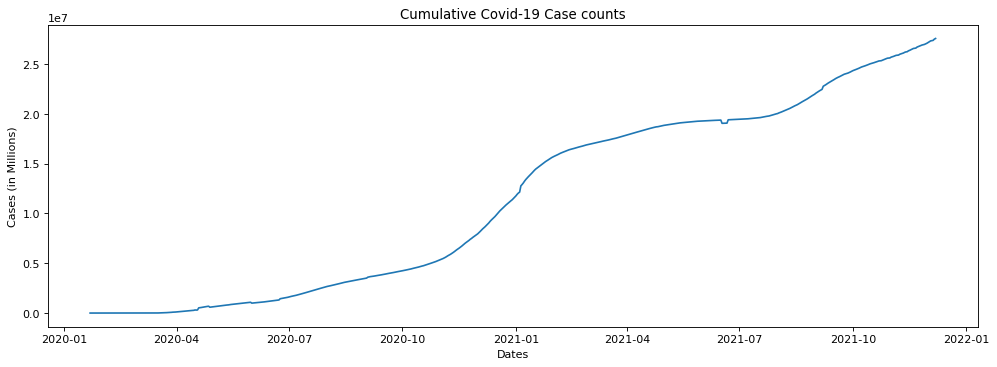

In [7]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data['Total_cases_cum'])
plt.ylabel('Cases (in Millions)')
plt.xlabel('Dates')
plt.title('Cumulative Covid-19 Case counts')

Text(0.5, 1.0, 'Cumulative Covid-19 Deaths')

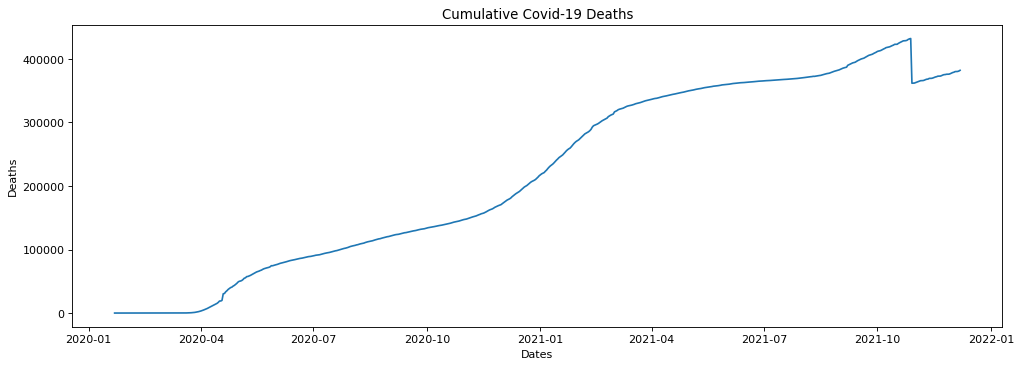

In [8]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data['Total_deaths_cum'])
plt.ylabel('Deaths')
plt.xlabel('Dates')
plt.title('Cumulative Covid-19 Deaths')

Text(0.5, 1.0, 'Daily Covid-19 Cases')

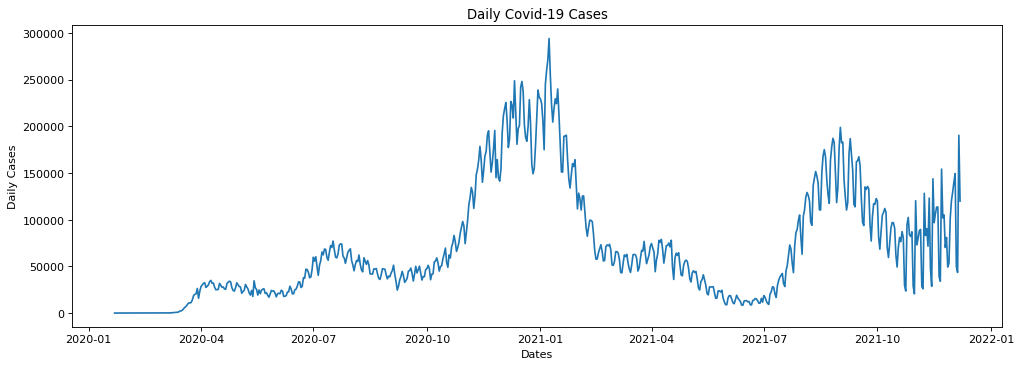

In [9]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data['daily_cases'])
plt.ylabel('Daily Cases')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Cases')

Text(0.5, 1.0, 'Daily Covid-19 Deaths')

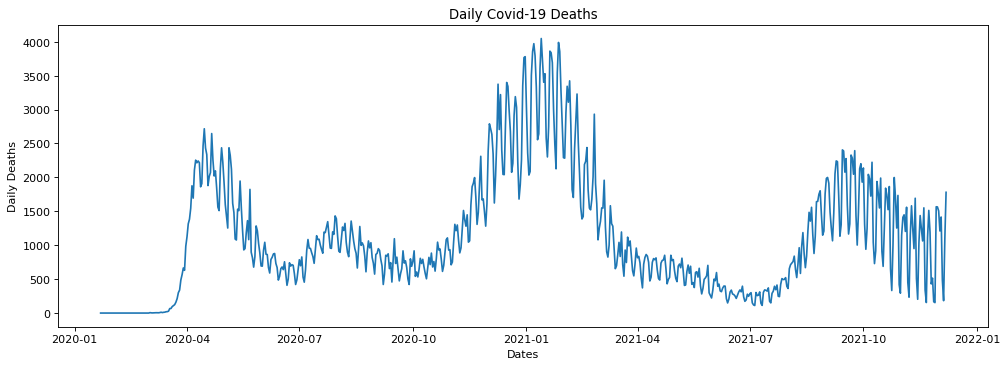

In [10]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data['daily_deaths'])
plt.ylabel('Daily Deaths')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Deaths')

#### Since the daily cases fluctuate quite a alot due to reporting inaccuracies and delays, we can consider taking a moving average to smoothen the curve, which can then be used for forecasting.

In [11]:
#7 day moving average
US_data['daily_deaths_sma7'] = US_data['daily_deaths'].rolling(window=7).mean()
US_data['daily_cases_sma7'] = US_data['daily_cases'].rolling(window=7).mean()

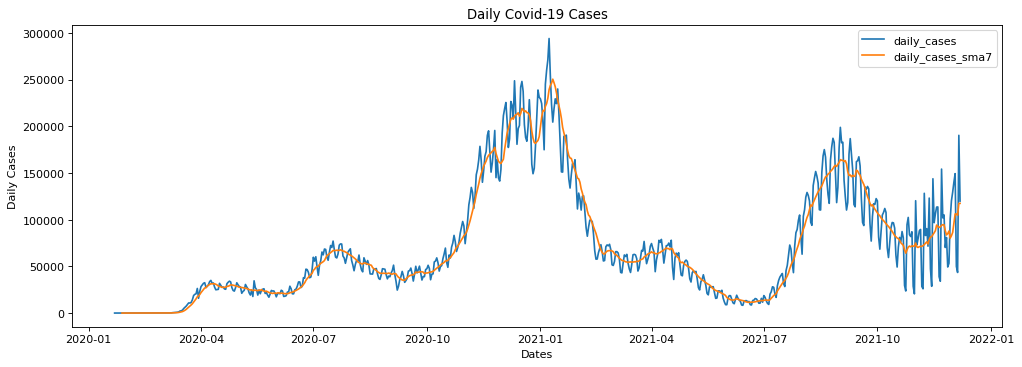

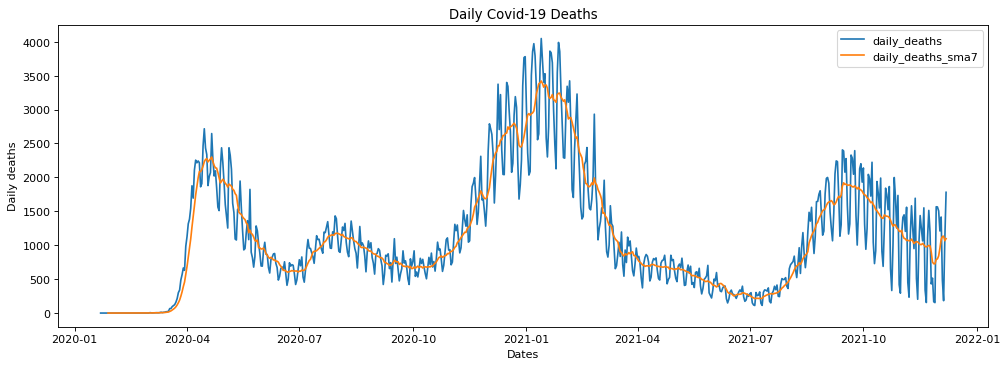

In [12]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data[['daily_cases','daily_cases_sma7']])
plt.ylabel('Daily Cases')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Cases')
plt.legend(['daily_cases','daily_cases_sma7'])


figure(figsize=(15, 5), dpi=80)
plt.plot(US_data[['daily_deaths','daily_deaths_sma7']])
plt.ylabel('Daily deaths')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Deaths')
plt.legend(['daily_deaths','daily_deaths_sma7'])

### Importing and Processing Twitter data  (US only tweets in English) for Covid-19
Source: http://www.panacealab.org/covid19/

Here, Keywords used for the tweets are:  COVD19, CoronavirusPandemic, COVID-19, 2019nCoV, CoronaOutbreak,coronavirus , WuhanVirus, covid19, coronaviruspandemic, covid-19, 2019ncov, coronaoutbreak, wuhanvirus.

While the dataset provided is for all Covid-19 related tweets worldwide, in all languages, for our analysis, we have used tweets originating in the US and in english.

This gives us a dataset having 2.15 million tweets from 21st January 2020 to 17th October 2021

In [13]:
twitter_data = pd.read_csv('full_dataset_clean_filtered.csv')

In [14]:
twitter_data.shape

(2150985, 6)

In [15]:
twitter_data.columns

Index(['Unnamed: 0', 'tweet_id', 'date', 'time', 'lang', 'country_place'], dtype='object')

In [16]:
twitter_data.tail()

Unnamed: 0             tweet_id        date      time lang  \
2150980   314645056  1449583894051831811  2021-10-17  03:51:46   en   
2150981   314645191  1449584548174389250  2021-10-17  03:54:22   en   
2150982   314645290  1449585061674639361  2021-10-17  03:56:25   en   
2150983   314645571  1449586158686584834  2021-10-17  04:00:46   en   
2150984   314645572  1449586160393756672  2021-10-17  04:00:47   en   

        country_place  
2150980            US  
2150981            US  
2150982            US  
2150983            US  
2150984            US

In [17]:
twitter_data['date'] = pd.to_datetime(twitter_data['date'])
tweet_counts = twitter_data['date'].dt.date.value_counts().sort_index().reset_index()
tweet_counts.columns = ['Date','tweet_count']
tweet_counts['Date'] = pd.to_datetime(tweet_counts['Date'])
tweet_counts

Date  tweet_count
0   2020-01-21            1
1   2020-01-22            6
2   2020-01-23            4
3   2020-01-24           13
4   2020-01-25            9
..         ...          ...
630 2021-10-13          747
631 2021-10-14          772
632 2021-10-15          571
633 2021-10-16          527
634 2021-10-17           91

[635 rows x 2 columns]

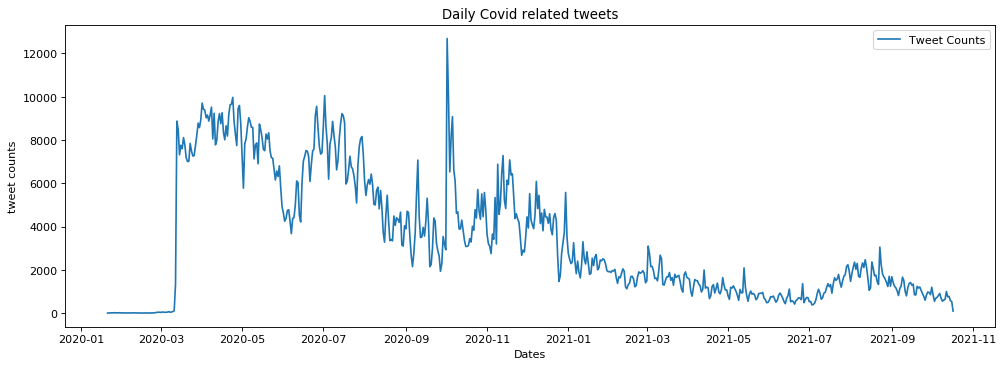

In [18]:
figure(figsize=(15, 5), dpi=80)
plt.plot(tweet_counts['Date'],tweet_counts['tweet_count'])
plt.ylabel('tweet counts')
plt.xlabel('Dates')
plt.title('Daily Covid related tweets')
plt.legend(['Tweet Counts'])

### Merging twitter counts and CDC data

In [19]:
# US_data['date']=Cases_data['date'].astype(str)
# tweet_counts['date']=tweet_counts['date'].astype(str)
merged = pd.merge(US_data,tweet_counts,how = 'inner',on = 'Date')
merged.dropna(inplace = True)
merged = merged.astype({'Total_cases_cum':'int64','Total_deaths_cum':'int64','daily_deaths_sma7':'int64','daily_cases_sma7':'int64'})

In [20]:
merged = merged[merged['Date'] > '2020-04-01']
merged.tail(30)

Date  Total_cases_cum  daily_cases  Total_deaths_cum  daily_deaths  \
604 2021-09-18         23592632       123111            399943          1590   
605 2021-09-19         23654317        97071            400530          1165   
606 2021-09-20         23707109        93706            401076          1315   
607 2021-09-21         23772566       135061            402219          2329   
608 2021-09-22         23839008       132408            403374          2285   
609 2021-09-23         23908527       135587            404326          2046   
610 2021-09-24         23962809       133090            405521          2394   
611 2021-09-25         23996899        95655            406105          1440   
612 2021-09-26         24025920        77086            406542          1002   
613 2021-09-27         24076295       103429            407370          1486   
614 2021-09-28         24129059       117124            408561          2128   
615 2021-09-29         24189990       116408            409531          2201   
616 2021-09-30         24254018       122567            410445          1930   
617 2021-10-01         24320427       120134            411707          2139   
618 2021-10-02         24365313        81362            412316          1310   
619 2021-10-03         24406079        68410            412722           940   
620 2021-10-04         24463763        87560            413443          1247   
621 2021-10-05         24513487       104890            414568          2044   
622 2021-10-06         24567370       107803            415540          1982   
623 2021-10-07         24626534       111990            416439          1724   
624 2021-10-08         24686318       107759            417669          2223   
625 2021-10-09         24725111        69965            418100          1044   
626 2021-10-10         24761955        59487            418417           729   
627 2021-10-11         24810546        75197            419038           917   
628 2021-10-12         24853589        91096            420048          1939   
629 2021-10-13         24904029        96989            420882          1776   
630 2021-10-14         24955027        96614            421677          1549   
631 2021-10-15         25006242        90947            422882          1990   
632 2021-10-16         25040364        62165            422961           912   
633 2021-10-17         25070303        49274            422989           688   

     daily_deaths_sma7  daily_cases_sma7  tweet_count  
604               1881            143337          848  
605               1886            140592          836  
606               1888            137726         1236  
607               1877            133853         1159  
608               1862            129469         1204  
609               1858            124933         1049  
610               1874            121433          912  
611               1853            117511          770  
612               1830            114656          594  
613               1854            116045          831  
614               1825            113482          973  
615               1813            111197          953  
616               1797            109337          850  
617               1760            107486         1195  
618               1742            105444          836  
619               1733            104204          547  
620               1699            101937          685  
621               1687            100190          724  
622               1656             98960          812  
623               1626             97449          907  
624               1638             95682          681  
625               1600             94053          547  
626               1570             92779          604  
627               1523             91013          632  
628               1508             89042          997  
629               1478             87497          747  
630              

### Forecasting Daily Covid-19 Cases using FbProphet with Tweet Counts as an external regressor

We shall feed our model with data upto 30th of September 2021 (Since our  twitter dataset is only upto 17th October) and forecast for the entire month of October 2021

In [21]:
#We shall feed our model with data upto 30th of September 2021 (Since our  twitter dataset is only upto 17th October) and forecast for the entire month of October 2021
input_df = merged[:616][['Date','daily_cases_sma7','tweet_count']]

In [22]:
input_df.rename(columns = {'Date':'ds','daily_cases_sma7':'y'},inplace= True)

In [23]:
input_df = input_df[input_df['ds'] <= '2021-09-30']

In [24]:
input_df

ds       y  tweet_count
70  2020-04-02   23504         9421
71  2020-04-03   25189         9383
72  2020-04-04   26883         9025
73  2020-04-05   27047         9154
74  2020-04-06   28868         8874
..         ...     ...          ...
612 2021-09-26  114656          594
613 2021-09-27  116045          831
614 2021-09-28  113482          973
615 2021-09-29  111197          953
616 2021-09-30  109337          850

[547 rows x 3 columns]

### Forecasting Daily Covid-19 Cases

In [25]:
from fbprophet import Prophet

In [26]:
#Initializing Fbprophet with trend flexibility
m = Prophet(yearly_seasonality=True, changepoint_range=1,changepoint_prior_scale=0.48)
#Adding the external regressor
m.add_regressor('tweet_count', mode = 'additive')

In [27]:
m.fit(df = input_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future = m.make_future_dataframe(periods = 31)
future
# tc = input_df[input_df['ds'] >= '2021-09-17']
future['tweet_count'] = input_df['tweet_count']
future.dropna(inplace = True)
future

ds  tweet_count
70  2020-06-11       9421.0
71  2020-06-12       9383.0
72  2020-06-13       9025.0
73  2020-06-14       9154.0
74  2020-06-15       8874.0
..         ...          ...
573 2021-10-27       2078.0
574 2021-10-28       1722.0
575 2021-10-29       1759.0
576 2021-10-30       1457.0
577 2021-10-31       1325.0

[508 rows x 2 columns]

In [29]:
forecast = m.predict(future)

In [30]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m,forecast)

### Evaluating Forecasted Daily Covid-19 Cases

In [31]:
input_df['predicted'] = forecast['yhat']

In [32]:
# input_df.dropna(inplace = True)
# input_df = input_df.astype({'predicted':'int64'})
# input_df.dtypes

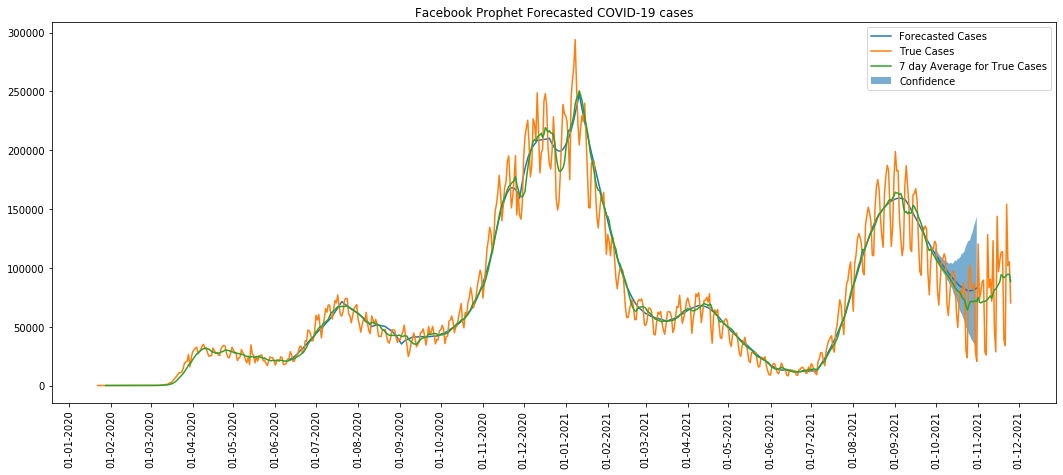

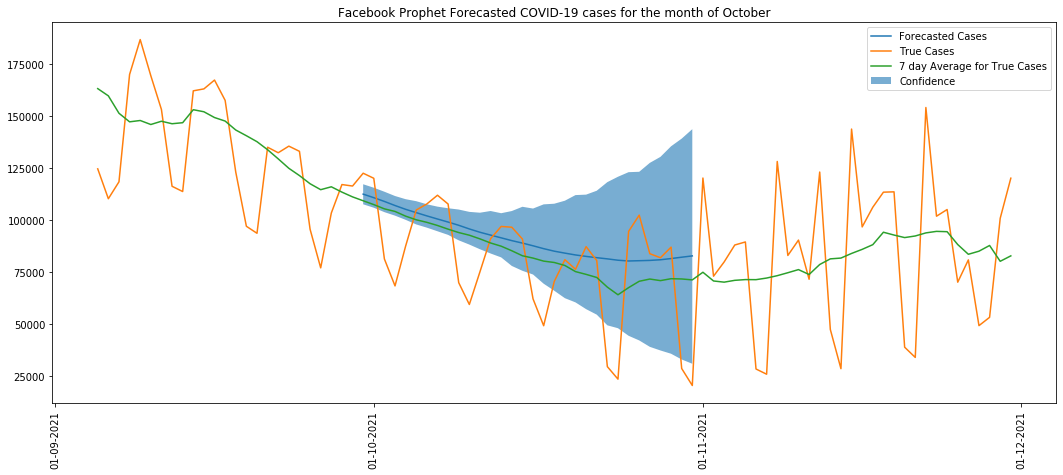


 The "forecast" DataFrame 



ds          trend    yhat_lower     yhat_upper    trend_lower  \
0   2020-06-11   65382.235859  17135.319873   26602.325275   65382.235859   
1   2020-06-12   63990.454894  17773.443691   27405.600858   63990.454894   
2   2020-06-13   62598.673929  18360.604627   28203.658111   62598.673929   
3   2020-06-14   61206.892964  19131.497300   29269.173138   61206.892964   
4   2020-06-15   59815.111999  19969.845565   29602.228035   59815.111999   
..         ...            ...           ...            ...            ...   
503 2021-10-27 -114562.221363  39129.328733  127538.498028 -155305.082364   
504 2021-10-28 -116349.801133  37380.577915  130422.435002 -159556.466451   
505 2021-10-29 -118137.380903  35808.914757  135507.679263 -164509.973146   
506 2021-10-30 -119924.960673  33054.941067  139189.747088 -168895.159513   
507 2021-10-31 -121712.540443  31000.576896  143737.117027 -173176.898168   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    65382.235859   -43642.641169         -43642.641169         -43642.641169   
1    63990.454894   -41515.527414         -41515.527414         -41515.527414   
2    62598.673929   -39408.571985         -39408.571985         -39408.571985   
3    61206.892964   -37370.833825         -37370.833825         -37370.833825   
4    59815.111999   -35261.894307         -35261.894307         -35261.894307   
..            ...             ...                   ...                   ...   
503 -65406.642421   195224.907604         195224.907604         195224.907604   
504 -64280.220168   197324.536216         197324.536216         197324.536216   
505 -64645.873787   199694.666047         199694.666047         199694.666047   
506 -62951.240941   202129.009325         202129.009325         202129.009325   
507 -61622.733289   204542.445164         204542.445164         204542.445164   

     extra_regressors_additive  ...      weekly  weekly_lower  weekly_upper  \
0                   709.331610  ...   26.585487     26.585487     26.585487   
1                   704.688376  ...  135.208337    135.208337    135.208337   
2                   660.944225  ...  168.653148    168.653148    168.653148   
3                   676.706782  ...  -16.386460    -16.386460    -16.386460   
4                   642.493479  ... -164.379794   -164.379794   -164.379794   
..                         ...  ...         ...           ...           ...   
503                -187.912254  ...  -41.187790    -41.187790    -41.187790   
504                -231.412025  ...   26.585487     26.585487     26.585487   
505                -226.890981  ...  135.208337    135.208337    135.208337   
506                -263.792472  ...  168.653148    168.653148    168.653148   
507                -279.921600  ...  -16.386460    -16.386460    -16.386460   

            yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0    -44378.558266  -44378.558266  -44378.558266                   0.0   
1    -42355.424127  -42355.424127  -42355.424127                   0.0   
2    -40238.169358  -40238.169358  -40238.169358                   0.0   
3    -38031.154147  -38031.154147  -38031.154147                   0.0   
4    -35740.007992  -35740.007992  -35740.007992                   0.0   
..             ...            ...            ...                   ...   
503  195454.007648  195454.007648  195454.007648                   0.0   
504  197529.362753  197529.362753  197529.362753                   0.0   
505  199786.348691  199786.348691  199786.348691                   0.0   
506  202224.148649  202224.148649  202224.148649                   0.0   
507  204838.753224  204838.753224  204838.753224                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  21739.594691  
1                           0.0                         0.0  22474.927480  
2                           0.0                 

In [33]:
fig = plt.figure(figsize = (18,7))
ax = fig.add_subplot(1,1,1)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Cases')
# plt.plot(input_df['ds'], input_df['y'], label='Historical True Input')
plt.plot(US_data[:'2021-11-25']['daily_cases'], label='True Cases')
plt.plot(US_data[:'2021-11-25']['daily_cases_sma7'], label='7 day Average for True Cases')
plt.fill_between(forecast[476:]['ds'], forecast[476:]['yhat_upper'], forecast[476:]['yhat_lower'],
                 alpha=.6, label='Confidence')
plt.title('Facebook Prophet Forecasted COVID-19 cases')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation = 90)

plt.legend()
# plt.savefig('prophet_forecast.png')
plt.show()

fig = plt.figure(figsize = (18,7))
ax = fig.add_subplot(1,1,1)
plt.plot(forecast[476:]['ds'], forecast[476:]['yhat'], label='Forecasted Cases')
# plt.plot(input_df['ds'], input_df['y'], label='Historical True Input')
plt.plot(US_data['2021-09-05':'2021-11-30']['daily_cases'], label='True Cases')
plt.plot(US_data['2021-09-05':'2021-11-30']['daily_cases_sma7'], label='7 day Average for True Cases')
plt.fill_between(forecast[476:]['ds'], forecast[476:]['yhat_upper'], forecast[476:]['yhat_lower'],
                 alpha=.6, label='Confidence')
plt.title('Facebook Prophet Forecasted COVID-19 cases for the month of October')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation = 90)

plt.legend()
# plt.savefig('prophet_forecast.png')
plt.show()

print('\n The "forecast" DataFrame \n')
forecast

In [34]:
US_data.reset_index(inplace = True)
score = r2_score(US_data.loc[(US_data['Date'] >= '2021-10-01') & (US_data['Date'] <= '2021-10-31')]['daily_cases_sma7'], forecast[forecast['ds'] >= '2021-10-01']['yhat'])
print('R2 Score is {}'.format(score))

R2 Score is 0.6432894684747203


## Part II: Prediction of Cumulative Covid-19 Cases using Tweet Sentiments Count as an External Regressor

### Importing and Processing Twitter Sentiment Data

Source: https://www.openicpsr.org/openicpsr/project/120321/version/V11/view

This dataset contains more than 198 million Twitter posts from January 28, 2020 to September 1, 2021, and the keywords covered include “corona”, “wuhan”, “nCov” and “covid”. Topic modeling techniques and pre-trained machine learning-based emotion analytic algorithms are used to label each tweet with qualitative sentiment attributes.

Get more information about the processing method from this paper: https://www.openicpsr.org/openicpsr/project/120321/version/V11/view?path=/openicpsr/120321/fcr:versions/V11/Twitter-COVID-dataset---Sep2021/COVID_Twitter_database_paper.pdf&type=file


In our analysis, only the daily tweet counts with different sentiments in the United States are needed, so preprocessed Twitter sentiment data are imported in this notebook. Preprocessing steps can be obtained from another notebook “Preprocessing Twitter Sentiment Data.ipynb”.

In [35]:
sentiment=pd.read_csv('sentiment_count.csv')

In [36]:
sentiment

date  very negative  negative  neutral or mixed  positive  \
0    2020-01-27             21       337                63        71   
1    2020-01-28            665      8899              2034      2059   
2    2020-01-29            723      8749              2204      2261   
3    2020-01-30            762      9986              2150      2506   
4    2020-01-31            567      8675              1989      2278   
..          ...            ...       ...               ...       ...   
579  2021-08-28           6960     44992              9233     11886   
580  2021-08-29           6995     41672              8124     10452   
581  2021-08-30           7838     54305             12062     16732   
582  2021-08-31           7087     52121             11461     16946   
583  2021-09-01           5191     41164              9686     13263   

     very positive  total  
0                1    493  
1               43  13700  
2               38  13975  
3               49  15453  
4               45  13554  
..             ...    ...  
579            375  73446  
580            290  67533  
581            455  91392  
582            441  88056  
583            348  69652  

[584 rows x 7 columns]

In [37]:
# change the data type
sentiment['date']=pd.to_datetime(sentiment['date'])

In [38]:
sentiment['total'].describe()

count       584.000000
mean      93709.505137
std       47856.896157
min         493.000000
25%       61979.000000
50%       89354.000000
75%      119250.250000
max      294400.000000
Name: total, dtype: float64

### Importing and Processing CDC Covid-19 Cases Data

In [39]:
covid_cases=pd.read_csv('CDC_dataset.csv')

In [40]:
# change the data type
covid_cases['submission_date']=pd.to_datetime(covid_cases['submission_date'],format='%m/%d/%Y')

In [41]:
covid_cases.dtypes

submission_date    datetime64[ns]
state                      object
tot_cases                   int64
conf_cases                float64
prob_cases                float64
new_case                    int64
pnew_case                 float64
tot_death                   int64
conf_death                float64
prob_death                float64
new_death                   int64
pnew_death                float64
created_at                 object
consent_cases              object
consent_deaths             object
dtype: object

In [42]:
# sort the records by date and reset the index
covid_cases=covid_cases.sort_values(by=['submission_date'])
covid_cases=covid_cases.reset_index(drop=True)

In [43]:
covid_cases.head()

submission_date state  tot_cases  conf_cases  prob_cases  new_case  \
0      2020-01-22    AS          0         NaN         NaN         0   
1      2020-01-22    PW          0         NaN         NaN         0   
2      2020-01-22    AK          0         NaN         NaN         0   
3      2020-01-22   FSM          0         NaN         NaN         0   
4      2020-01-22    WA          0         NaN         NaN         0   

   pnew_case  tot_death  conf_death  prob_death  new_death  pnew_death  \
0        NaN          0         NaN         NaN          0         NaN   
1        NaN          0         NaN         NaN          0         NaN   
2        NaN          0         NaN         NaN          0         NaN   
3        NaN          0         NaN         NaN          0         NaN   
4        0.0          0         NaN         NaN          0         NaN   

               created_at consent_cases consent_deaths  
0  03/26/2020 04:22:39 PM           NaN            NaN  
1  03/26/2020 04:22:39 PM           NaN            NaN  
2  03/26/2020 04:22:39 PM           NaN            NaN  
3  03/26/2020 04:22:39 PM         Agree          Agree  
4  01/24/2020 12:00:00 AM           NaN            NaN

In [44]:
# group by date to get the counts of cases each day, and reorganize the dataset
cases=covid_cases[['submission_date','new_case','pnew_case','new_death','tot_cases','tot_death']]
cases=cases.groupby('submission_date').sum().reset_index()
cases=cases.rename(columns={'submission_date':'date'})
cases

date  new_case  pnew_case  new_death  tot_cases  tot_death
0   2020-01-22         0        0.0          0          0          0
1   2020-01-23         1        0.0          0          1          0
2   2020-01-24         1        0.0          0          2          0
3   2020-01-25         0        0.0          0          2          0
4   2020-01-26         1        0.0          0          3          0
..         ...       ...        ...        ...        ...        ...
681 2021-12-03    149321    29395.0       1416   48918909     785308
682 2021-12-04     49887     9262.0        487   48968796     785795
683 2021-12-05     43452     5995.0        182   49012248     785977
684 2021-12-06    190298    20447.0       1099   49202546     787123
685 2021-12-07    119895    23187.0       1780   49322567     788903

[686 rows x 6 columns]

### Merging Twitter Sentiment Data and Covid-19 Cases Data

In [45]:
# merge the sentiment dataset and COVID cases dataset together to get the full dataset
full_df=sentiment.merge(cases,how='left',left_on='date',right_on='date')

In [46]:
# rename the columns
full_df=full_df.rename(columns={'total':'sentiment_total','pnew_case':'possible_new_case'})

In [47]:
# get total number of negative tweets by adding up negative and very negative tweets counts
full_df['negative_total']=full_df['negative']+full_df['very negative']
# get total number of positive tweets by adding up positive and very positive tweets counts
full_df['positive_total']=full_df['positive']+full_df['very positive']

In [48]:
full_df

date  very negative  negative  neutral or mixed  positive  \
0   2020-01-27             21       337                63        71   
1   2020-01-28            665      8899              2034      2059   
2   2020-01-29            723      8749              2204      2261   
3   2020-01-30            762      9986              2150      2506   
4   2020-01-31            567      8675              1989      2278   
..         ...            ...       ...               ...       ...   
579 2021-08-28           6960     44992              9233     11886   
580 2021-08-29           6995     41672              8124     10452   
581 2021-08-30           7838     54305             12062     16732   
582 2021-08-31           7087     52121             11461     16946   
583 2021-09-01           5191     41164              9686     13263   

     very positive  sentiment_total  new_case  possible_new_case  new_death  \
0                1              493         0                0.0          0   
1               43            13700         0                0.0          0   
2               38            13975         0                0.0          0   
3               49            15453         0                0.0          0   
4               45            13554         1                0.0          0   
..             ...              ...       ...                ...        ...   
579            375            73446    151236            24688.0       1449   
580            290            67533    118276            17965.0       1148   
581            455            91392    134665            21536.0       1208   
582            441            88056    176990            38315.0       1758   
583            348            69652    198879            41043.0       1984   

     tot_cases  tot_death  negative_total  positive_total  
0            3          0             358              72  
1            3          0            9564            2102  
2            3          0            9472            2299  
3            3          0           10748            2555  
4            4          0            9242            2323  
..         ...        ...             ...             ...  
579   38874999     642765           51952           12261  
580   38993454     643946           48667           10742  
581   39128202     645189           62143           17187  
582   39305696     646997           59208           17387  
583   39504898     649017           46355           13611  

[584 rows x 14 columns]

### Exploratory Data Analysis

### 1. Analyzing the trend of the number of tweets with different sentiments

The discussion on the COVID-related topic is gradually decreasing over time. People seem to become numb to the pandemic. While the counts of negative tweets have dropped sharply, the neutral and positive reviews have remained stable. To some extent, this shows that people are getting accustomed to the existence of the virus, and their overall sentimental tendency is gradually becoming neutral.<p>

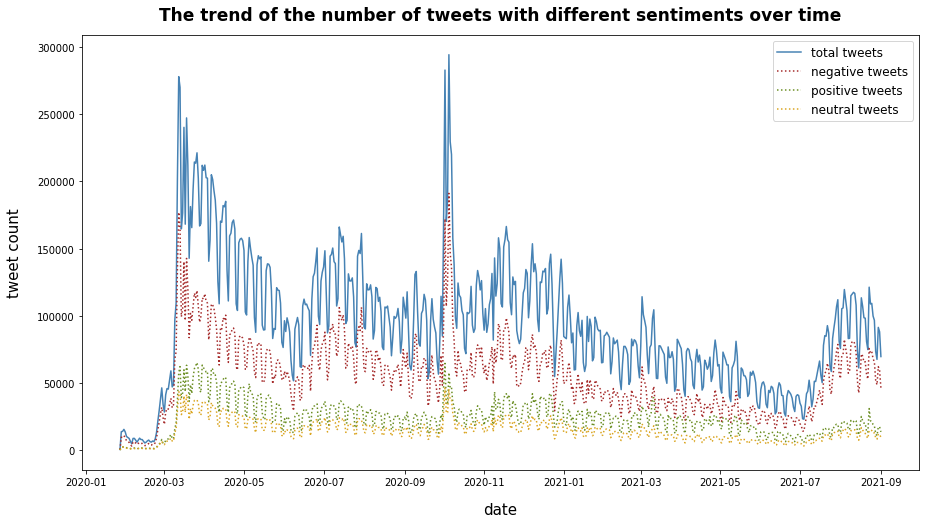

In [49]:
plt.figure(figsize=(15,8)) 
x=full_df['date']
plt.plot(x,full_df['sentiment_total'],c='#4682B4',label='total tweets')
plt.plot(x,full_df['negative_total'],c='#A52A2A',linestyle='dotted',label='negative tweets')
plt.plot(x,full_df['positive_total'],c='#6B8E23',linestyle='dotted',label='positive tweets')
plt.plot(x,full_df['neutral or mixed'],c='#DAA520',linestyle='dotted',label='neutral tweets')
plt.xlabel('date',fontsize=15,labelpad=15)
plt.ylabel('tweet count',fontsize=15,labelpad=15)
plt.title('The trend of the number of tweets with different sentiments over time',fontsize=17,y=1.02,fontweight='bold')
plt.legend(prop={'size': 12})
plt.show()

### 2. Analyzing the relationship between Twitter data and COVID-19 case data

We are trying to find the relationship between the sentimentally labeled Twitter data and the COVID cases data by creating scatter plots. Connections are found between **negative tweets count and new confirmed cases**, **very negative tweets count and new deaths**, **neutral or mixed tweets count and new possible confirmed cases**.

A common pattern can also be found among the three scatter plots. According to the record date, the development of the epidemic can be divided into three stages. **In different stages, the relationship between the Twitter data and COVID-19 case data has different characteristics**.

The color bar in the scatter plot is drawn according to the index, which is also the order of the date. Therefore, the darker dots represent the data points at the beginning of the epidemic, and the lighter dots represent the most recent epidemic data. The x-axis represents the number of tweets with the specific sentiment, and the y-axis represents the number of COVID cases.

Take the first scatter plot as an example. At the beginning of the epidemic (the purple dots), there were lots of negative tweets, but few cases were confirmed. During the outbreak phase (the green dots), the number of confirmed cases increased sharply, but there were not as many negative tweets as in the first phase. Recently (the yellow dots), with the widespread use of vaccines, newly confirmed cases have been controlled to a certain extent, and the discussion of the epidemic is also at a moderate level. This is completely consistent with what we have observed in reality. As the epidemic goes from the beginning to the outbreak and then to be controlled, people are becoming accustomed to the existence of the epidemic.

#### 1) Analyzing the connection between negative tweets count and new confirmed cases

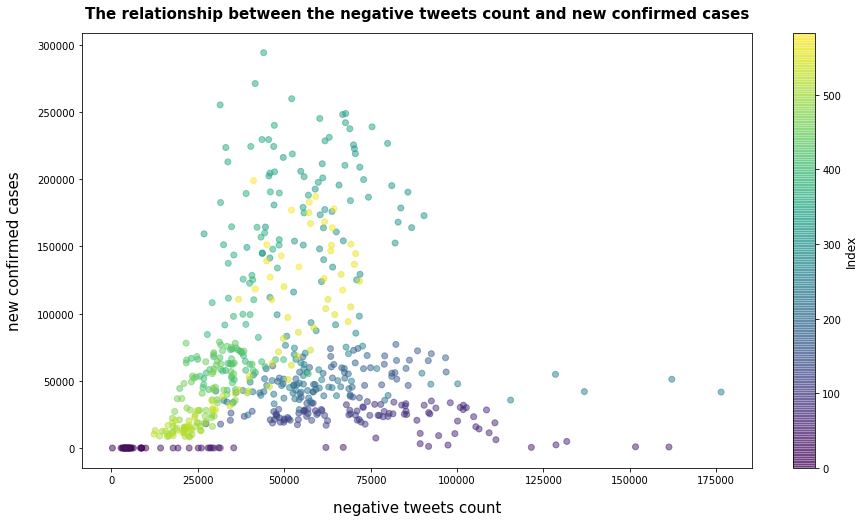

In [50]:
plt.figure(figsize=(15,8)) 
plt.scatter(full_df['negative'],full_df['new_case'],c=full_df.index,alpha=0.5)
plt.xlabel('negative tweets count',fontsize=15,labelpad=15)
plt.ylabel('new confirmed cases',fontsize=15,labelpad=15)
plt.title('The relationship between the negative tweets count and new confirmed cases',fontsize=15,y=1.02,fontweight='bold')
plt.colorbar().set_label(label='Index',size=12)

#### 2) Analyzing the connection between very negative tweets count and new deaths

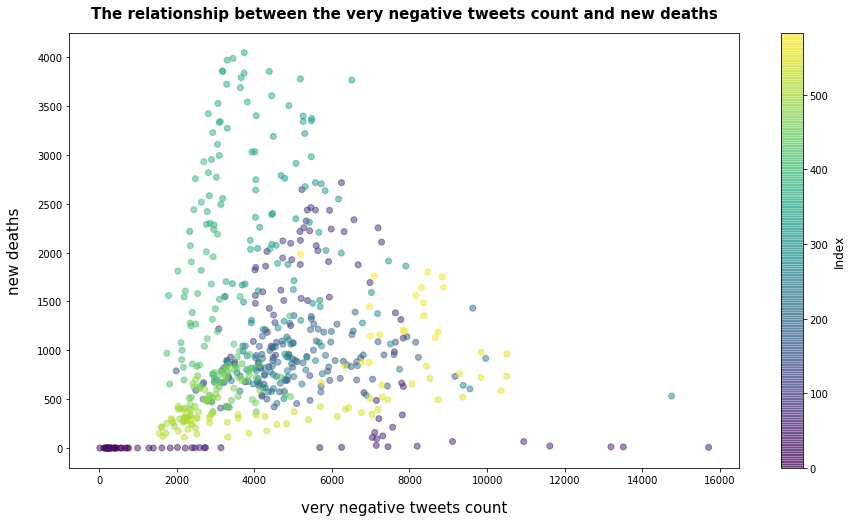

In [51]:
plt.figure(figsize=(15,8)) 
plt.scatter(full_df['very negative'],full_df['new_death'],c=full_df.index,alpha=0.5)
plt.xlabel('very negative tweets count',fontsize=15,labelpad=15)
plt.ylabel('new deaths',fontsize=15,labelpad=15)
plt.title('The relationship between the very negative tweets count and new deaths',fontsize=15,y=1.02,fontweight='bold')
plt.colorbar().set_label(label='Index',size=12)

#### 3) Analyzing the connection between neutral or mixed tweets count and possible new cases

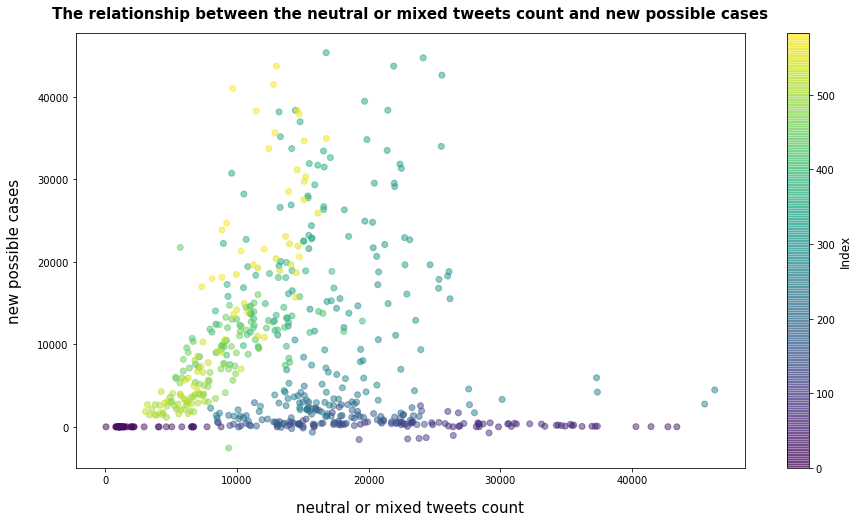

In [52]:
plt.figure(figsize=(15,8)) 
plt.scatter(full_df['neutral or mixed'],full_df['possible_new_case'],c=full_df.index,alpha=0.5)
plt.xlabel('neutral or mixed tweets count',fontsize=15,labelpad=15)
plt.ylabel('new possible cases',fontsize=15,labelpad=15)
plt.title('The relationship between the neutral or mixed tweets count and new possible cases',fontsize=15,y=1.02,fontweight='bold')
plt.colorbar().set_label(label='Index',size=12)

### Data Preparation for Forecasting

In [53]:
full_df.head()

date  very negative  negative  neutral or mixed  positive  \
0 2020-01-27             21       337                63        71   
1 2020-01-28            665      8899              2034      2059   
2 2020-01-29            723      8749              2204      2261   
3 2020-01-30            762      9986              2150      2506   
4 2020-01-31            567      8675              1989      2278   

   very positive  sentiment_total  new_case  possible_new_case  new_death  \
0              1              493         0                0.0          0   
1             43            13700         0                0.0          0   
2             38            13975         0                0.0          0   
3             49            15453         0                0.0          0   
4             45            13554         1                0.0          0   

   tot_cases  tot_death  negative_total  positive_total  
0          3          0             358              72  
1          3          0            9564            2102  
2          3          0            9472            2299  
3          3          0           10748            2555  
4          4          0            9242            2323

In [54]:
# caculate the cumulative negative/positive/neutral tweets count
full_df['cum_neg_total']=full_df['negative_total'].cumsum()
full_df['cum_pos_total']=full_df['positive_total'].cumsum()
full_df['cum_neu_total']=full_df['neutral or mixed'].cumsum()
full_df.head()

date  very negative  negative  neutral or mixed  positive  \
0 2020-01-27             21       337                63        71   
1 2020-01-28            665      8899              2034      2059   
2 2020-01-29            723      8749              2204      2261   
3 2020-01-30            762      9986              2150      2506   
4 2020-01-31            567      8675              1989      2278   

   very positive  sentiment_total  new_case  possible_new_case  new_death  \
0              1              493         0                0.0          0   
1             43            13700         0                0.0          0   
2             38            13975         0                0.0          0   
3             49            15453         0                0.0          0   
4             45            13554         1                0.0          0   

   tot_cases  tot_death  negative_total  positive_total  cum_neg_total  \
0          3          0             358              72            358   
1          3          0            9564            2102           9922   
2          3          0            9472            2299          19394   
3          3          0           10748            2555          30142   
4          4          0            9242            2323          39384   

   cum_pos_total  cum_neu_total  
0             72             63  
1           2174           2097  
2           4473           4301  
3           7028           6451  
4           9351           8440

In [55]:
# create the dataset for modeling
pre_data=full_df[['date','tot_cases','cum_neg_total','cum_pos_total','cum_neu_total']].set_index('date')
pre_data

tot_cases  cum_neg_total  cum_pos_total  cum_neu_total
date                                                              
2020-01-27          3            358             72             63
2020-01-28          3           9922           2174           2097
2020-01-29          3          19394           4473           4301
2020-01-30          3          30142           7028           6451
2020-01-31          4          39384           9351           8440
...               ...            ...            ...            ...
2021-08-28   38874999       31790435       14102151        8517132
2021-08-29   38993454       31839102       14112893        8525256
2021-08-30   39128202       31901245       14130080        8537318
2021-08-31   39305696       31960453       14147467        8548779
2021-09-01   39504898       32006808       14161078        8558465

[584 rows x 4 columns]

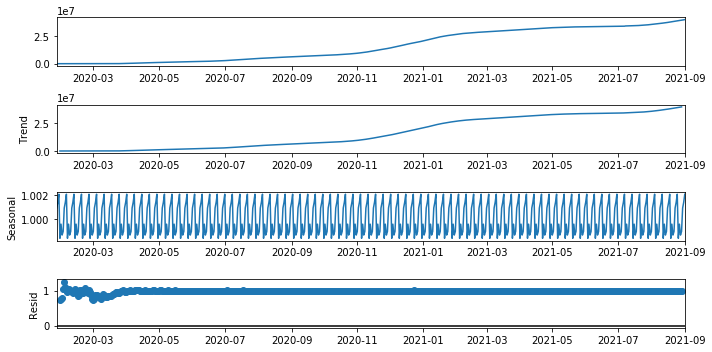

In [56]:
# decompose the time series into trend, seasonal and residual components
# Because the cases are increasing at a non-linear rate, multiplicative model is more appropriate
result = seasonal_decompose (pre_data[['tot_cases']], model='multiplicative')  
rcParams['figure.figsize'] = 10, 5
result.plot()
plt.show()

### Forecasting Cumulative Covid-19 Cases using Time Series Models

We will use 95% of the data as the training set and 5% of the data as the test set to evaluate the prediction performance of the model.

In [57]:
# split training set and test set 
train=pre_data.iloc[:int(pre_data.shape[0]*0.95)]
test=pre_data.iloc[int(pre_data.shape[0]*0.95):]
pred=test.copy()

From the decomposition diagram above, we can clearly see that our time series have a seasonal component, so it makes sense to use a seasonal ARIMA model.

First, we are going to build an **ARIMA model** as a baseline model, and then train a **SARIMA model** on this basis. Finally, based on the pattern between the Twitter data with sentiment labels and COVID-19 cases that we found, the tweet counts of different sentiments will be added as exogenous variables to the **SARIMAX model**, helping us predict the cumulative confirmed cases.

In order to build the models, we will need to choose p, d, q values. There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc. In this project we decide to use a simpler approach, that is to perform a grid search over multiple values of p, d, q. According to the different combination of p, d, q values, we can calculate and compare some performance criteria, such as AIC and BIC.

Therefore, we are going to use the pmdarima library for Python to help us quickly perform the gird search. With the function auto_arima, we can set a range of p, d, q values, then the model will be trained for the combination of parameter values. The model with the lowest (best) AIC score will be reported back.

#### 1. ARIMA Model

In [58]:
model_arima= auto_arima(train["tot_cases"],trace=True, error_action='ignore', 
                        start_p=1,start_q=1,max_p=3,max_q=3,
                        suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(train["tot_cases"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=12180.695, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=12163.830, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=12126.504, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=12117.689, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=12170.342, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=12125.695, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=12126.536, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=12119.585, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=12163.215, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=12118.393, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=12056.692, Time=0.34 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=11988.667, Time=0.63 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12139.650, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=12098.923, Time=0.12 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=12011.211, Time=0.43

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [59]:
prediction_arima=model_arima.predict(len(test))
pred["ARIMA Model Prediction"]=prediction_arima

In [60]:
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(test["tot_cases"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  548188.0078717167


In [61]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["tot_cases"],mode='lines+markers',name="Train Data for Cumulative Confirmed Cases"))
fig.add_trace(go.Scatter(x=test.index, y=test["tot_cases"],mode='lines+markers',name="Test Data for Cumulative Confirmed Cases",))
fig.add_trace(go.Scatter(x=test.index, y=pred["ARIMA Model Prediction"],mode='lines+markers',name="Prediction for Cumulative Confirmed Cases",))
fig.update_layout(title="ARIMA Prediction for Cumulative Confirmed Cases",xaxis_title="Date",yaxis_title="Cumulative Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### 2. SARIMA Model

In [62]:
model_sarima= auto_arima(train["tot_cases"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                         suppress_warnings=True,stepwise=False,seasonal=True)
model_sarima.fit(train["tot_cases"])

 ARIMA(0,2,0)(0,0,0)[7]             : AIC=12178.786, Time=0.01 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=12146.086, Time=0.06 sec
 ARIMA(0,2,0)(0,0,2)[7]             : AIC=12136.203, Time=0.13 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=12130.198, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=12078.490, Time=0.15 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=12081.519, Time=0.34 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=12114.255, Time=0.07 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=12079.327, Time=0.27 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=12082.302, Time=0.84 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=12161.956, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=12101.858, Time=0.09 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=12078.716, Time=0.24 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=12069.369, Time=0.06 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=12015.245, Time=0.23 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=12016.337, Time=0.46

ARIMA(order=(1, 2, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [63]:
prediction_sarima=model_sarima.predict(len(test))
pred["SARIMA Model Prediction"]=prediction_sarima

In [64]:
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(test["tot_cases"],prediction_sarima)))

Root Mean Square Error for SARIMA Model:  393635.88660032785


In [65]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["tot_cases"],mode='lines+markers',name="Train Data for Cumulative Confirmed Cases"))
fig.add_trace(go.Scatter(x=test.index, y=test["tot_cases"],mode='lines+markers',name="Test Data for Cumulative Confirmed Cases",))
fig.add_trace(go.Scatter(x=test.index, y=pred["SARIMA Model Prediction"],mode='lines+markers',name="Prediction for Cumulative Confirmed Cases",))
fig.update_layout(title="SARIMA Prediction for Cumulative Confirmed Cases",xaxis_title="Date",yaxis_title="Cumulative Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

#### 3. SARIMAX Model

In order to further improve the accuracy of the prediction, we added the number of tweets with different sentiments (positive, negative and neutral) as exogenous variables.

In [66]:
sxmodel = auto_arima(train['tot_cases'],trace=True,error_action='ignore',
                     exogenous=train[['cum_neg_total','cum_pos_total','cum_neu_total']],
                     start_p=0, start_q=0,max_p=2, max_q=2, m=7,
                     suppress_warnings=True,stepwise=True,seasonal=True)
sxmodel.fit(train["tot_cases"],exogenous=train[['cum_neg_total','cum_pos_total','cum_neu_total']])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=12075.971, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=15102.973, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=12085.703, Time=0.30 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=12088.299, Time=0.19 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=12138.038, Time=0.20 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=12123.683, Time=0.23 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=12076.904, Time=0.52 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=12079.113, Time=0.78 sec
 ARIMA(0,2,0)(0,0,2)[7]             : AIC=12129.172, Time=0.33 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=12109.100, Time=0.36 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=12079.978, Time=1.32 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=12031.804, Time=0.29 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=12108.904, Time=0.25 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=12033.177, Time=0.73 sec
 ARIMA(1,2,0)(1,0,2

ARIMA(order=(2, 2, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [67]:
prediction_sx=sxmodel.predict(len(test),exogenous=test[['cum_neg_total','cum_pos_total','cum_neu_total']])
pred["SARIMAX Model Prediction"]=prediction_sx

In [68]:
print("Root Mean Square Error for SARIMAX Model: ",np.sqrt(mean_squared_error(test["tot_cases"],prediction_sx)))

Root Mean Square Error for SARIMAX Model:  379512.4153053012


In [69]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["tot_cases"],mode='lines+markers',name="Train Data for Cumulative Confirmed Cases"))
fig.add_trace(go.Scatter(x=test.index, y=test["tot_cases"],mode='lines+markers',name="Test Data for Cumulative Confirmed Cases",))
fig.add_trace(go.Scatter(x=test.index, y=pred["SARIMAX Model Prediction"],mode='lines+markers',name="Prediction for Cumulative Confirmed Cases",))
fig.update_layout(title="SARIMAX Prediction for Cumulative Confirmed Cases",xaxis_title="Date",yaxis_title="Cumulative Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

According to the RMSEs of three different models, we will finally choose the **SARIMAX model** to predict the cumulative Covid-19 cases.

The cumulative confirmed cases from August 3 to September 1 predicted by three models are as follows:

In [70]:
pred

tot_cases  cum_neg_total  cum_pos_total  cum_neu_total  \
date                                                                 
2021-08-03   35318662       30118618       13620019        8196232   
2021-08-04   35443081       30200969       13641061        8212388   
2021-08-05   35572457       30276765       13661987        8227462   
2021-08-06   35706187       30346759       13682157        8241154   
2021-08-07   35826267       30404018       13697989        8251111   
2021-08-08   35923439       30462382       13713113        8260860   
2021-08-09   36017485       30540761       13735159        8275379   
2021-08-10   36154254       30621607       13756009        8289954   
2021-08-11   36299114       30702680       13777198        8305175   
2021-08-12   36450988       30781845       13799570        8320292   
2021-08-13   36597676       30854089       13821340        8334214   
2021-08-14   36736995       30905836       13835247        8343073   
2021-08-15   36847712       30948406       13846548        8350411   
2021-08-16   36958164       31001208       13864578        8361652   
2021-08-17   37109237       31072792       13889603        8378440   
2021-08-18   37278536       31142867       13911568        8393535   
2021-08-19   37453778       31208417       13931599        8406541   
2021-08-20   37622688       31274230       13951575        8418963   
2021-08-21   37765976       31330611       13965720        8429275   
2021-08-22   37893106       31383529       13978771        8438139   
2021-08-23   38010648       31459156       14009707        8452890   
2021-08-24   38174807       31531425       14031507        8467622   
2021-08-25   38352954       31604737       14052827        8482226   
2021-08-26   38540361       31672730       14071877        8495010   
2021-08-27   38723402       31738483       14089890        8507899   
2021-08-28   38874999       31790435       14102151        8517132   
2021-08-29   38993454       31839102       14112893        8525256   
2021-08-30   39128202       31901245       14130080        8537318   
2021-08-31   39305696       31960453       14147467        8548779   
2021-09-01   39504898       32006808       14161078        8558465   

            ARIMA Model Prediction  SARIMA Model Prediction  \
date                                                          
2021-08-03            3.530942e+07             3.530871e+07   
2021-08-04            3.542242e+07             3.541075e+07   
2021-08-05            3.553741e+07             3.553016e+07   
2021-08-06            3.564400e+07             3.563695e+07   
2021-08-07            3.573853e+07             3.573442e+07   
2021-08-08            3.582677e+07             3.582502e+07   
2021-08-09            3.591951e+07             3.592992e+07   
2021-08-10            3.602441e+07             3.603935e+07   
2021-08-11            3.614031e+07             3.615130e+07   
2021-08-12            3.625815e+07             3.627995e+07   
2021-08-13            3.636784e+07             3.639662e+07   
2021-08-14            3.646585e+07             3.650443e+07   
2021-08-15            3.655778e+07             3.660571e+07   
2021-08-16            3.665409e+07             3.672058e+07   
2021-08-17            3.676222e+07             3.683977e+07   
2021-08-18            3.688104e+07             3.696134e+07   
2021-08-19            3.700174e+07             3.709878e+07   
2021-08-20            3.711455e+07             3.722485e+07   
2021-08-21            3.721603e+07             3.734248e+07   
2021-08-22            3.731163e+07             3.745392e+07   
2021-08-23            3.741151e+07             3.757828e+07   
2021-08-24            3.752287e+07             3.770672e+07   
2021-08-25            3.764461e+07             3.783745e+07   
2021-08-26            3.776819e+07             3.798325e+07   
2021-08-27            3.788411e+07             3.811824e+07   
2021-08-28            3.798906e+07             3.824522e+07   
2021-08